# Test Recurrent Policy with Extreme Parameter Variation 

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../RL_lib/Models')
sys.path.append('../../../Asteroid3dof_env')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_Meta-Learning-master/Experiments/Asteroid_3DOF/Asteroid_PV_sphere


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

3-dof dynamics model
lander model apf
Glideslope Constraint: delta =  3
Flat Constraint


<IPython.core.display.Javascript object>


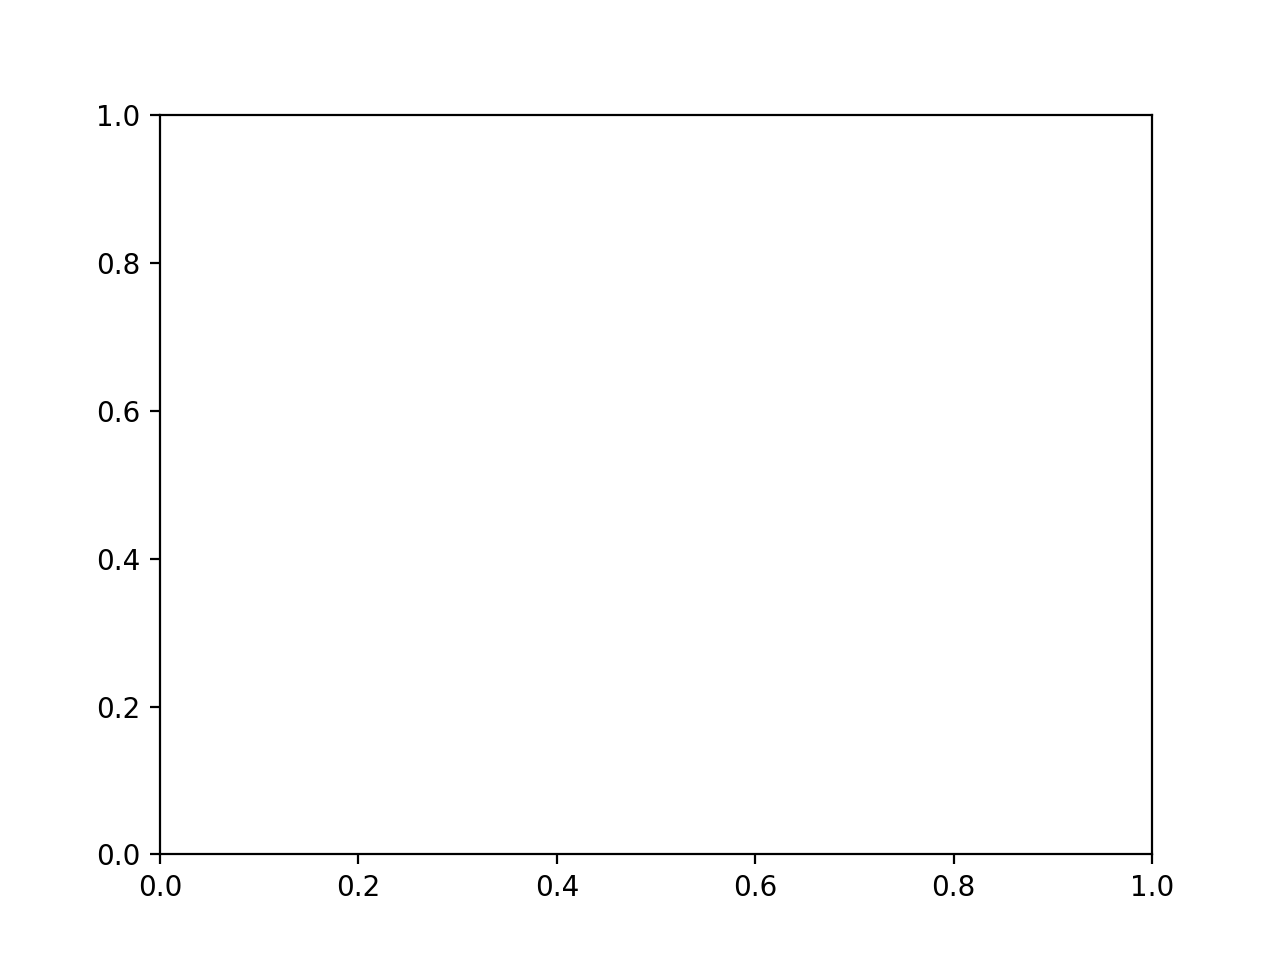

<IPython.core.display.Javascript object>


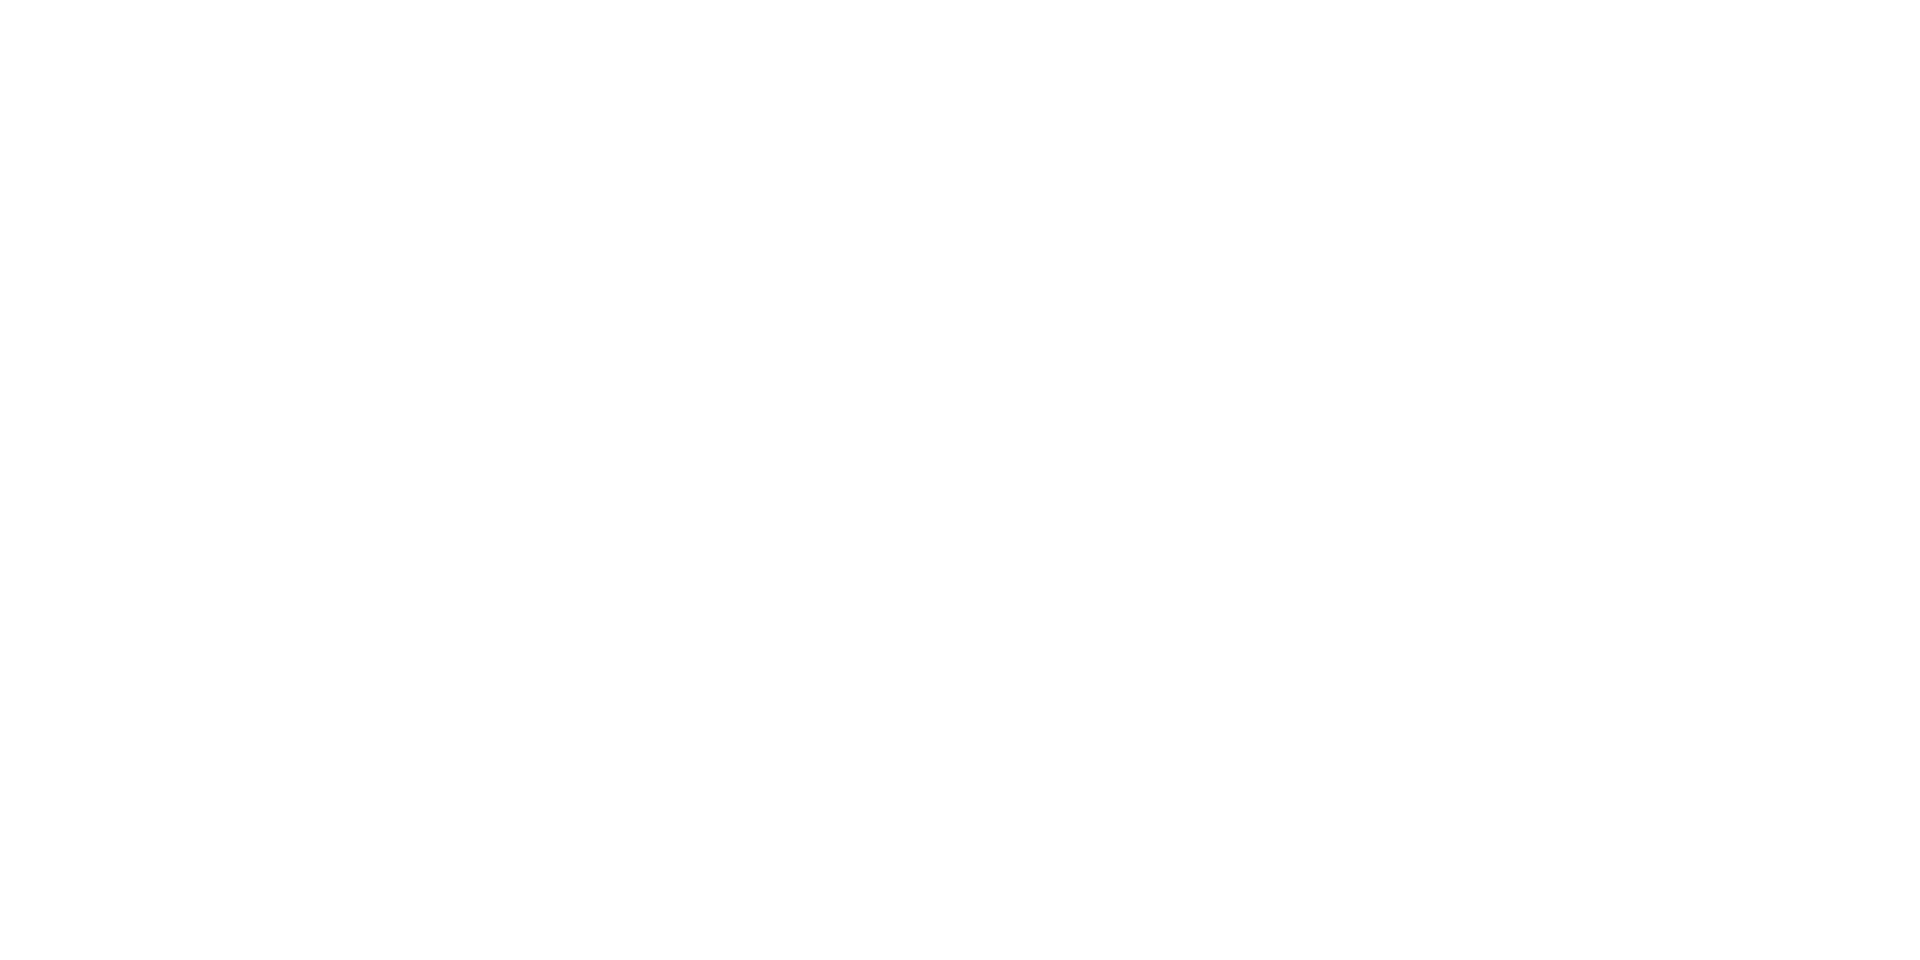

<IPython.core.display.Javascript object>


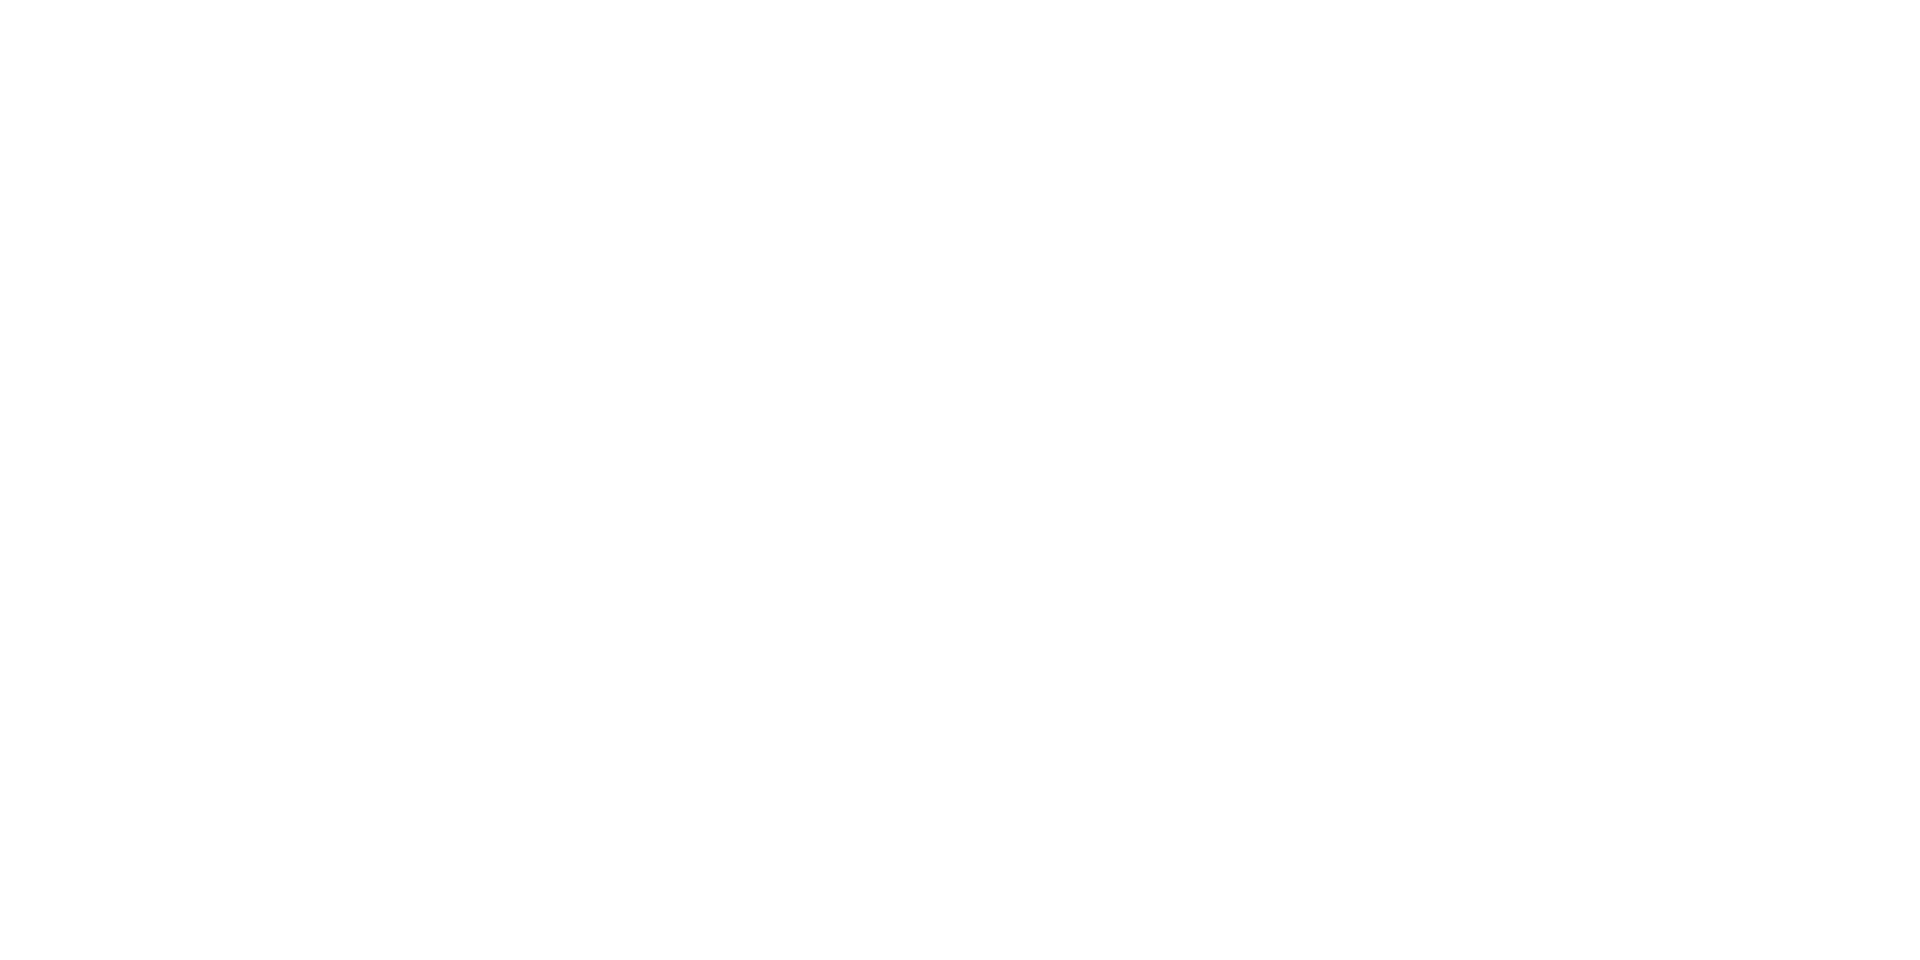

<IPython.core.display.Javascript object>


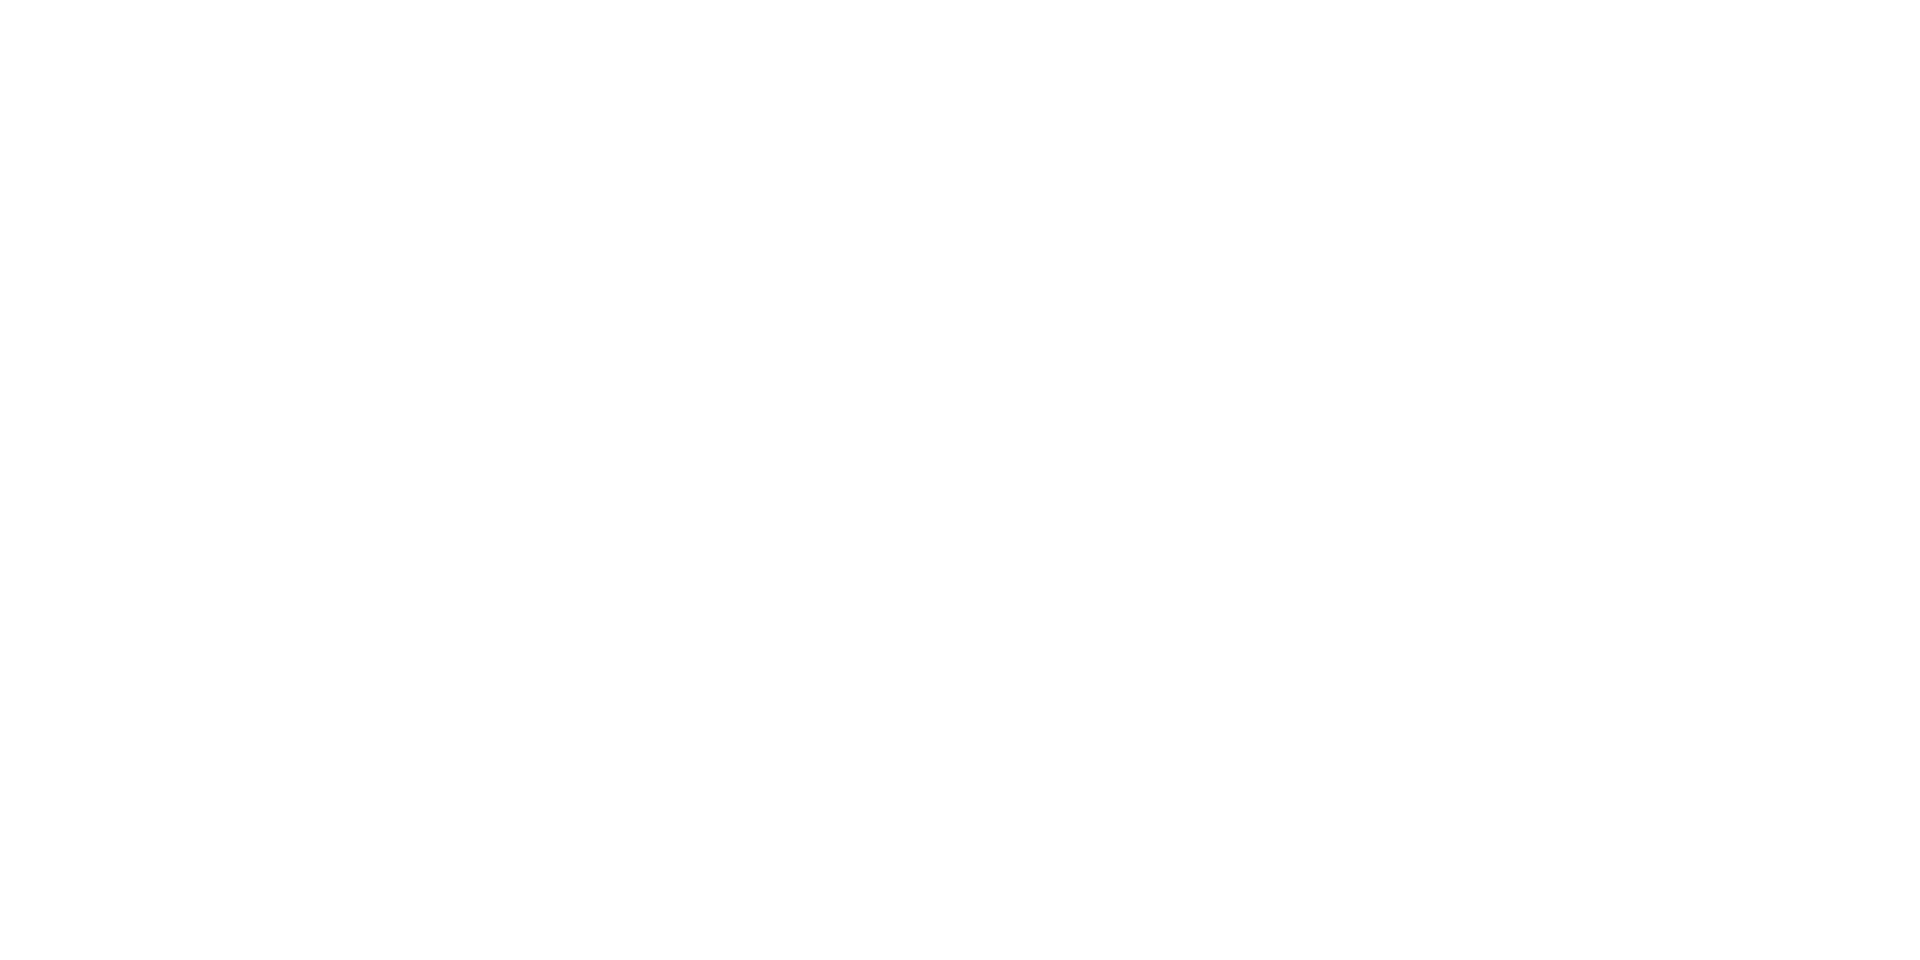

<IPython.core.display.Javascript object>


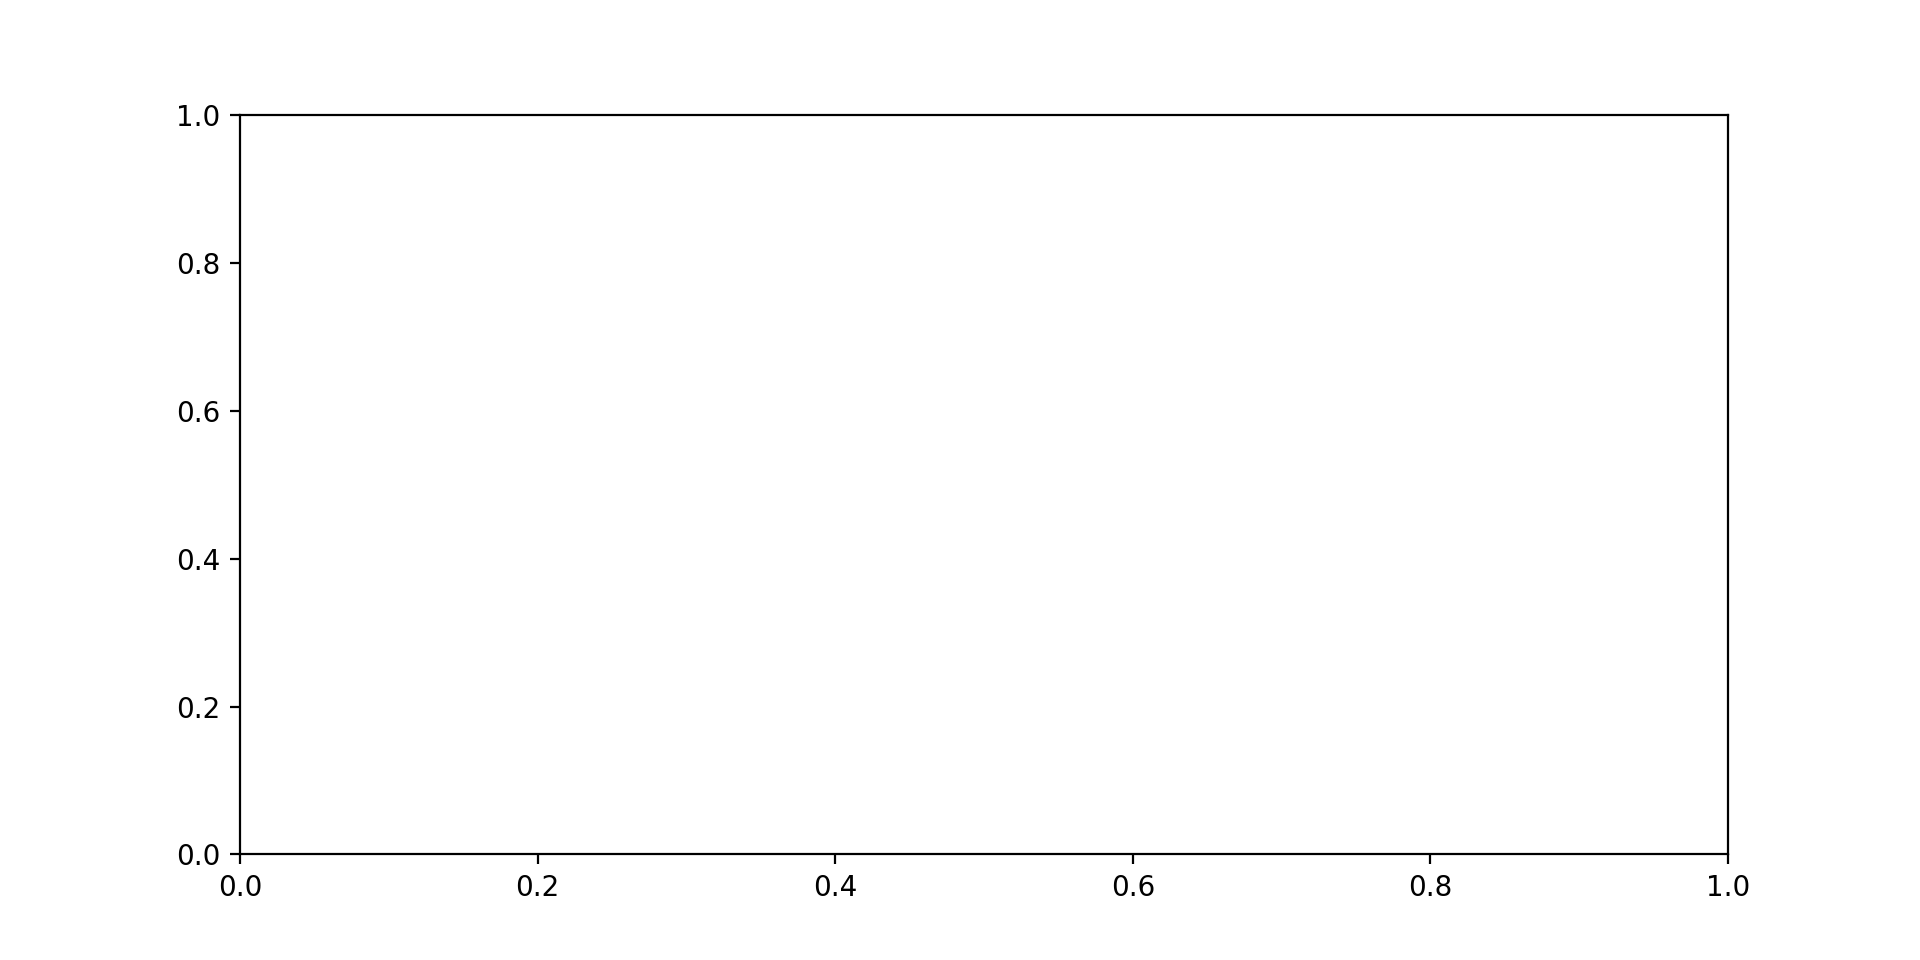

Lander Env
Landing_icgen:
    adjust_apf_v0               :  False
    w (min/max)                 :  (-0.001, -0.001, -0.001) (0.001, 0.001, 0.001)
 mass (min/max)                 :  450 500
  srp (min/max)                 :  (-1e-06, -1e-06, -1e-06) (1e-06, 1e-06, 1e-06)
M (min/max)                     :  (20000000000.0, 200000000000.0)
Position Theta                  :  (0, 0.7853981633974483)
Position Phi                    :  (-3.141592653589793, 3.141592653589793)
Policy with vectorized sample
	xn_init: layer  Linear(in_features=4, out_features=40, bias=True)
	xn_init: layer  Linear(in_features=40, out_features=34, bias=True)
	xn_init: layer  Linear(in_features=34, out_features=30, bias=True)
	xn_init: layer  Linear(in_features=30, out_features=3, bias=True)
[[-1.]
 [ 0.]
 [ 1.]]
	Test Mode:          False
	Clip Param:         0.1
	Shuffle :           True
	Max Grad Norm:      30
	Recurrent Steps:    1
	Rollout Limit:      1
Value Funtion
	xn_init: layer  Linear(in_features=4, ou

In [3]:
from env import Env
import env_utils as envu
from dynamics_model_wo import Dynamics_model
from lander_model import Lander_model
from ic_gen_sphere import Landing_icgen
import rl_utils

from arch_policy_vf import Arch

from model import Model
from policy import Policy
from value_function import Value_function

import pcm_model_nets as model_nets
import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward


logger = rl_utils.Logger()
dynamics_model = Dynamics_model(landing_target=np.asarray([0., 0., 250.]))
lander_model = Lander_model(apf_tau1=300, apf_tau2=300, apf_vf1=-0.2, apf_vf2=-0.01, apf_atarg=20, apf_v0=1.0,
                           sensor_bias_range=(-0.0,0.0))
lander_model.min_thrust = 0
lander_model.max_thrust = 2
lander_model.get_state_agent = lander_model.get_state_agent2
lander_model.apf_pot = lander_model.apf_pot2
obs_dim = 4
act_dim = 3
recurrent_steps = 1

reward_object = Reward(landing_coeff=10.0, landing_rlimit=1, landing_vlimit=0.2, 
                       tracking_coeff=-1.00, fuel_coeff=-0.01, landing_gslimit=-1)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          tf_limit=5000.0,print_every=10,
           nav_period=6)


min_w   = -1.0e-3
max_w   =  1.0e-3


env.ic_gen = Landing_icgen(adjust_apf_v0=False,
                            position_theta=(0,np.pi/4),
                            min_mass = 450, max_mass=500,
                            min_w=(min_w,min_w,min_w),  max_w=(max_w,max_w,max_w))

                            
                          
                           
env.ic_gen.show()

arch = Arch()

policy = Policy(policy_nets.MLP1(obs_dim, act_dim), shuffle=True,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30,
                init_func=rl_utils.xn_init, discretize=True)
value_function = Value_function(valfunc_nets.MLP1(obs_dim), 
                                shuffle=True, batch_size=256, max_grad_norm=30)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)

fname = "MLP-sphere"
policy.load_params(fname)
value_function.load_params(fname)

# Test Policy 

In [5]:
print(1)
policy.test_mode=True  
env.test_policy_batch(agent,10000,print_every=100)

1
Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.31 |  1.19 |  0.00 |  3.46 |     0
glideslope | 9.572 |27.358 | 0.235 |2123.848 |    55
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.023 |   0.007 |   0.004 |   0.038
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.1    -0.1    -0.0 |     0.1     0.2    -0.0
velocity |  -0.002   0.001  -0.017 |   0.010   0.011   0.007 |  -0.027  -0.025  -0.034 |   0.029   0.026  -0.002
fuel     |  1.01 |  0.16 |  0.68 |  1.46
glideslope |  6.71 | 23.12 |  0.88 |229.81
Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  200
Cumulative Sta

Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  1100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.28 |  1.19 |  0.00 |  3.46 |     0
glideslope | 9.128 |32.270 | 0.194 |10921.248 |   566
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.003 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002   0.000  -0.016 |   0.010   0.010   0.007 |  -0.033  -0.029  -0.034 |   0.035   0.037  -0.000
fuel     |  1.00 |  0.17 |  0.62 |  1.73
glideslope |  5.47 | 11.24 |  0.88 |229.81
Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  1200
Cumulative St

i :  2100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.29 |  1.19 |  0.00 |  3.46 |     0
glideslope | 8.706 |28.106 | 0.169 |10921.248 |   566
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.003 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002   0.000  -0.016 |   0.010   0.010   0.007 |  -0.034  -0.029  -0.036 |   0.035   0.037  -0.000
fuel     |  1.00 |  0.18 |  0.61 |  1.75
glideslope |  5.26 | 10.71 |  0.79 |229.81
Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  2200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.29 |  1.19 |  0.00 |  3.46 |     0
glideslope | 8.631 |27.729 | 0.169 |10921.248 |   566
sc_margin |100.000 | 0.000 |100.000 |

i :  3100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.29 |  1.19 |  0.00 |  3.46 |     0
glideslope | 8.849 |29.156 | 0.148 |10921.248 |   566
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.003 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002   0.000  -0.016 |   0.010   0.010   0.007 |  -0.034  -0.029  -0.036 |   0.035   0.037  -0.000
fuel     |  1.00 |  0.18 |  0.61 |  1.75
glideslope |  5.28 | 11.11 |  0.79 |307.09
Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  3200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.29 |  1.19 |  0.00 |  3.46 |     0
glideslope | 8.790 |28.874 | 0.148 |10921.248 |   566
sc_margin |100.000 | 0.000 |100.000 |

i :  4100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.29 |  1.19 |  0.00 |  3.46 |     0
glideslope | 8.864 |28.167 | 0.148 |10921.248 |   566
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.002 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002   0.000  -0.016 |   0.010   0.010   0.007 |  -0.034  -0.034  -0.036 |   0.035   0.037  -0.000
fuel     |  1.00 |  0.18 |  0.60 |  1.75
glideslope |  5.29 | 10.62 |  0.79 |307.09
Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  4200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.29 |  1.19 |  0.00 |  3.46 |     0
glideslope | 8.836 |27.975 | 0.119 |10921.248 |   566
sc_margin |100.000 | 0.000 |100.000 |

norm_vf  |   0.021 |   0.007 |   0.002 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.000  -0.016 |   0.010   0.010   0.007 |  -0.034  -0.034  -0.037 |   0.035   0.037  -0.000
fuel     |  1.00 |  0.18 |  0.56 |  1.94
glideslope |  5.22 | 10.18 |  0.79 |307.09
Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  5200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.29 |  1.19 |  0.00 |  3.46 |     0
glideslope | 8.831 |27.218 | 0.119 |10921.248 |   566
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.002 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |   

norm_vf  |   0.021 |   0.007 |   0.002 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.000  -0.016 |   0.010   0.010   0.007 |  -0.034  -0.038  -0.037 |   0.035   0.037   0.000
fuel     |  1.00 |  0.18 |  0.56 |  1.94
glideslope |  5.20 |  9.82 |  0.79 |307.09
Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  6200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.29 |  1.19 |  0.00 |  3.46 |     0
glideslope | 8.841 |26.915 | 0.119 |10921.248 |   566
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.002 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |   

Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  7200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.29 |  1.19 |  0.00 |  3.46 |     0
glideslope | 8.826 |26.880 | 0.119 |10921.248 |   566
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.002 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.000  -0.016 |   0.010   0.010   0.007 |  -0.034  -0.038  -0.037 |   0.035   0.037   0.000
fuel     |  1.00 |  0.18 |  0.56 |  1.94
glideslope |  5.15 |  9.46 |  0.79 |307.09
Dynamics: Max Disturban

Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  8200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.29 |  1.19 |  0.00 |  3.46 |     0
glideslope | 8.813 |26.697 | 0.119 |10921.248 |   566
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.002 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.000  -0.016 |   0.010   0.010   0.007 |  -0.034  -0.038  -0.037 |   0.035   0.037   0.000
fuel     |  1.00 |  0.18 |  0.56 |  1.94
glideslope |  5.20 |  9.86 |  0.79 |307.09
Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  8300
Cumulative St

Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  9200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.29 |  1.19 |  0.00 |  3.46 |     0
glideslope | 8.854 |27.047 | 0.119 |10921.248 |   566
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.002 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.000  -0.016 |   0.010   0.010   0.007 |  -0.034  -0.038  -0.037 |   0.035   0.037   0.000
fuel     |  1.00 |  0.18 |  0.56 |  1.94
glideslope |  5.22 |  9.96 |  0.79 |307.09
Dynamics: Max Disturbance (m/s^2):  [0.00904375 0.00818691 0.00697861] 0.014054037024534264
Dynamics: Max w:                    [-0.00080519  0.00088338 -0.0009033 ]
i :  9300
Cumulative St

In [103]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_trajectories(trajectory_list, linewidth=0.1, 
                      min_axislimit=(-1200.,-1200.,-600.), max_axislimit=(1200,1200,1200),
                      r_ast=250., target_loc=np.asarray([0.,0.,250.])):
    plt.clf()
    fig = plt.figure(11)
    ax = fig.gca(projection='3d')
    pi = np.pi
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]

        
    x = r_ast*np.sin(phi)*np.cos(theta)
    y = r_ast*np.sin(phi)*np.sin(theta)
    z = r_ast*np.cos(phi)

            
    ax.plot_surface( x,y,z,  linewidth=0, antialiased=False, shade=True, color='gray')
    rf_list = []
    vf_list = []
    ff_list = []
    for i in range(len(trajectory_list)):
        plot_traj( ax, trajectory_list[i],target_loc, linewidth=linewidth)
        rf_list.append(trajectory_list[i]['norm_rf'][-1])
        vf_list.append(trajectory_list[i]['norm_vf'][-1] * 100.)
        #print('foo: ', trajectory_list[i]['norm_vf'][-1])
        ff_list.append(trajectory_list[i]['fuel'][-1])
    #print(np.asarray(vf_list))
    ax.legend
    fig.canvas.draw()
    plt.show()

    ax.set_xlim3d(min_axislimit[0], max_axislimit[0])
    ax.set_ylim3d(min_axislimit[1], max_axislimit[1])
    ax.set_zlim3d(min_axislimit[2], max_axislimit[2])

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    
    #s = '100 Random Trajectories Executed in \nEnvironment with Unknown Dynamics'
    #plt.figtext(0.25,0.3, s , style='normal',fontsize=11,
    #            bbox={'facecolor':'white', 'alpha':1.0, 'pad':10})
    

def plot_traj( ax, trajectory, target_loc, linewidth=0.1):
    pos = np.asarray(trajectory['position'])
    pos += target_loc
    ax.plot(pos[:,0],pos[:,1],pos[:,2],linewidth=linewidth)
    




<IPython.core.display.Javascript object>


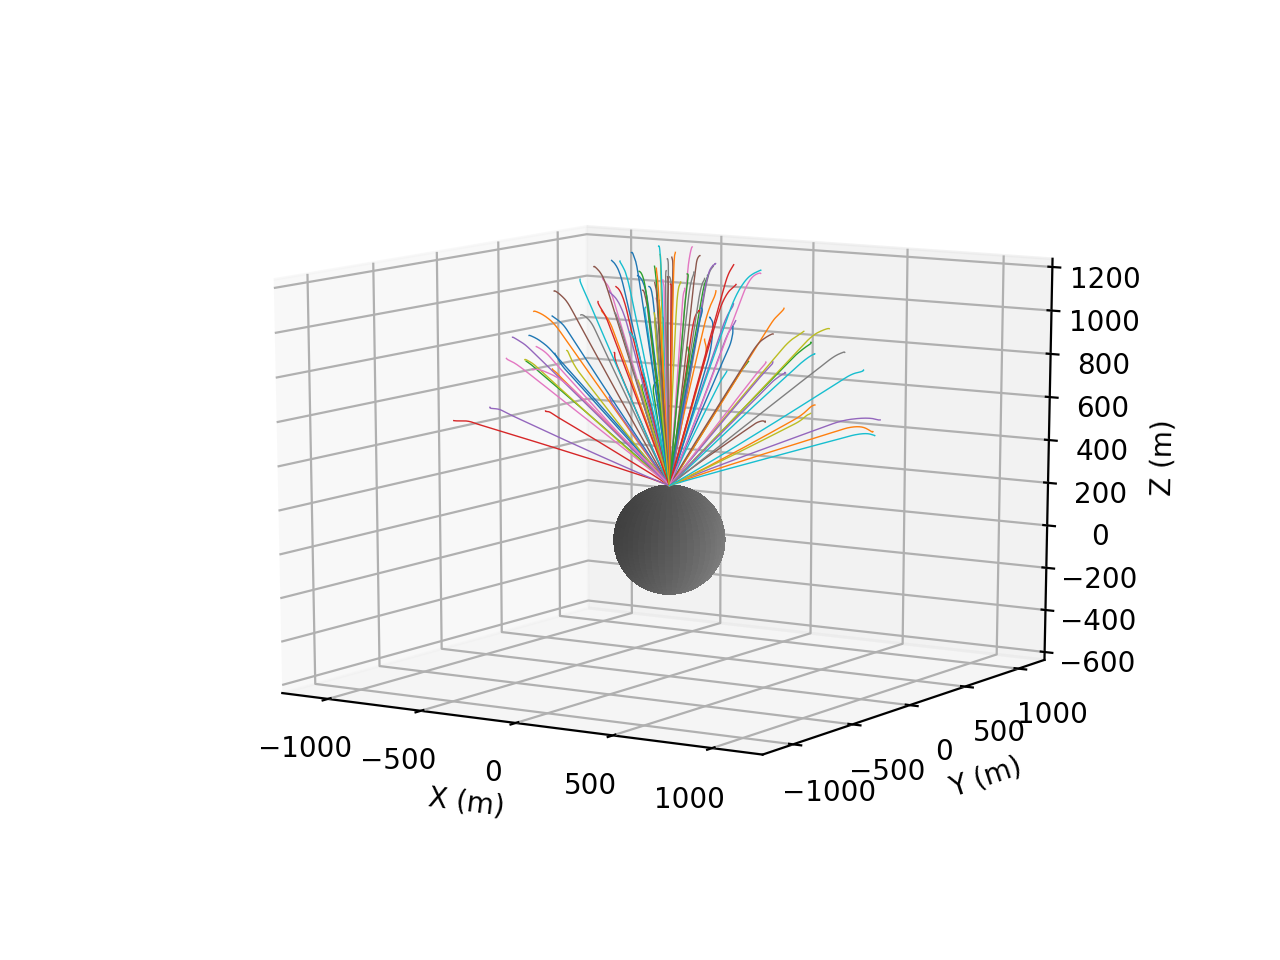

In [104]:
plot_trajectories(lander_model.trajectory_list,linewidth=0.5)

In [36]:
len(lander_model.trajectory_list)
traj_list = lander_model.trajectory_list[0:100]
len(traj_list)
np.save(fname + '_100traj',traj_list)

<IPython.core.display.Javascript object>


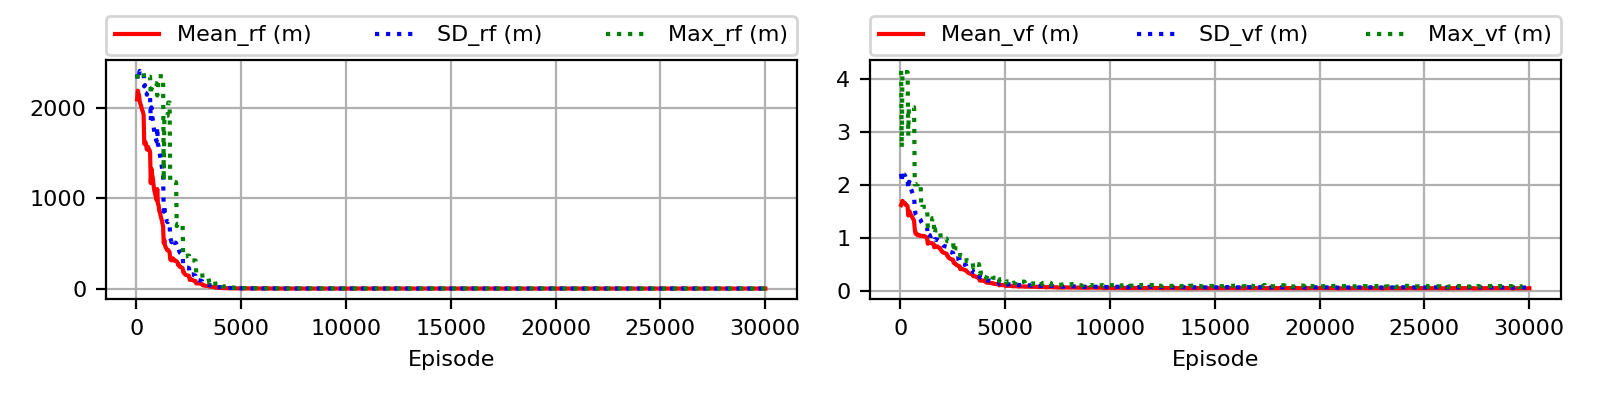

In [17]:


envu.plot_rf_vf(env.rl_stats.history)

In [5]:
policy.test_mode=True  
env.ic_gen.min_w=(-1.1e-3,-1.1e-3,1.1e-3)

v1 = -0.05
v2 = -0.05
v3 = 0.05
env.ic_gen.velocity_x=(v1,v1)
env.ic_gen.velocity_y=(v2,v2)
env.ic_gen.velocity_z=(v3,v3)
env.ic_gen.M = (20e10,20e10)
env.ic_gen.max_w = env.ic_gen.min_w
env.test_policy_batch(agent,1000,print_every=100)
print(np.linalg.norm(dynamics_model.max_disturbance))

Dynamics: Max Disturbance (m/s^2):  [0.00346957 0.00323558 0.00388835] 0.006134020850947553
Dynamics: Max w:                    [-0.0011 -0.0011  0.0011]
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.69 |  1.20 |  0.00 |  3.46 |     0
glideslope |10.747 |24.017 | 0.086 |273.633 |    78
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.008 |   0.005 |   0.046
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.1    -0.1    -0.0 |     0.2     0.1    -0.0
velocity |  -0.003   0.002  -0.015 |   0.011   0.011   0.006 |  -0.030  -0.035  -0.031 |   0.025   0.029  -0.003
fuel     |  1.40 |  0.16 |  1.05 |  1.77
glideslope |  4.15 |  3.97 |  1.05 | 26.74
Dynamics: Max Disturbance (m/s^2):  [0.00356067 0.00323558 0.00388835] 0.006186007801595387
Dynamics: Max w:                    [-0.0011 -0.0011  0.0011]
Dynamics: Max Disturbance (m/s^2):  [0.00357417 0.

norm_vf  |   0.087 |   0.000 |   0.087 |   0.087
norm_rf  |   998.7 |    57.7 |   900.2 |  1099.4
position |    -0.5     6.0   901.8 |   297.8   298.5    98.8 |  -729.3  -759.6   641.5 |   739.6   684.9  1097.2
velocity |  -0.050  -0.050   0.050 |   0.000   0.000   0.000 |  -0.050  -0.050   0.050 |  -0.050  -0.050   0.050
fuel     |  0.00 |  0.00 |  0.00 |  0.00
glideslope |100.00 |  0.00 |100.00 |100.00
0.006294512242000453
